# Super Resolution 구현하기

## 1 - 1. 고해상도 이미지 활용하기

In [1]:
import os
import matplotlib.image as img
import tensorflow as tf
from skimage import data
import matplotlib.pyplot as plt
import cv2
import numpy as np

hr_image_dir = os.getenv('HOME') + "/aiffel/super_resolution/g_high.jpg"
lr_image_dir = os.getenv('HOME') + "/aiffel/super_resolution/g_row.jpg"

(1200, 1920, 3)


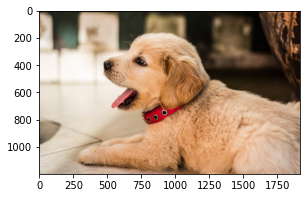

In [4]:
hr_image = img.imread(hr_image_dir)

hr_shape = hr_image.shape[:2]

print(hr_image.shape) # 이미지의 크기를 출력합니다.

plt.figure(figsize=(6,3))
plt.imshow(hr_image)

해상도 낮은 영상 만들기

(300, 480, 3)


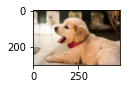

In [5]:
lr_image = cv2.resize(hr_image, dsize=(hr_shape[1]//4, hr_shape[0]//4)) # (가로 픽셀 수, 세로 픽셀 수)

print(lr_image.shape)

plt.figure(figsize=(3,1))
plt.imshow(lr_image)

#### pretrained srgan 모델 사용

In [6]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

def apply_srgan(image):
    image = tf.cast(image[np.newaxis,], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [7]:
srgan_img = apply_srgan(lr_image)

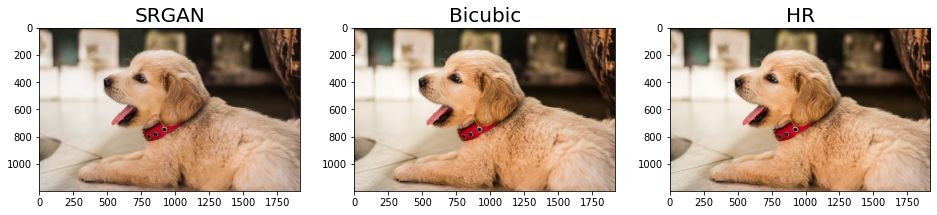

In [8]:
bicubic_image = cv2.resize(
    lr_image, 
    dsize=(hr_shape[1], hr_shape[0]), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

images = [srgan_img, bicubic_image, hr_image]
titles = ["SRGAN", "Bicubic", "HR"]

plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

####  DIV2K로 학습한 SRGAN이기 때문에 학습 데이터와 유사한 강아지(동물) 이미지를 입력으로 사용했다.

- SRGAN이 학습한 DIV2K 이미지들의 픽셀 확률 분포와 유사한 '강아지' 이미지를 입력으로 사용해서 만족스러운 **SRGAN** 이미지를 얻었다.

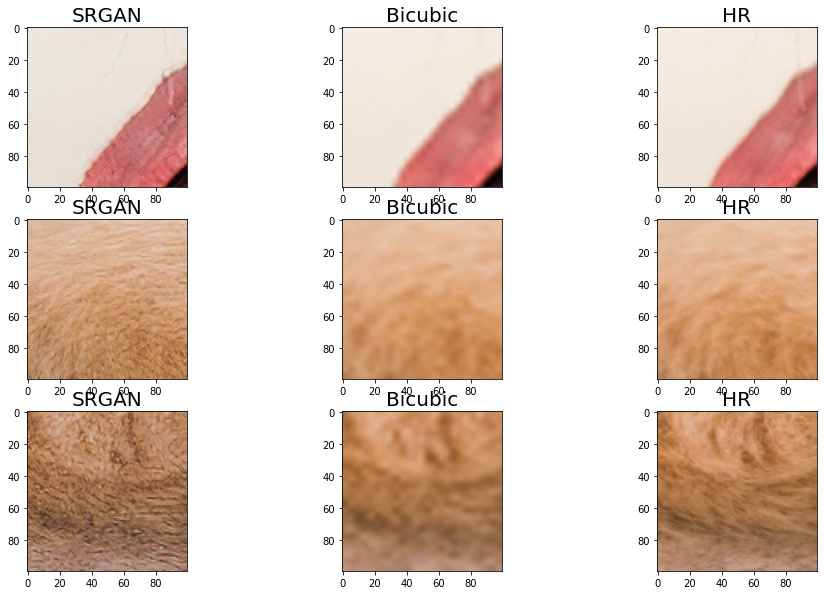

In [9]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=100, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(600,500)] *3 + [(1000,500)] *3 + [(1100,800)] *3

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

___

## 1 - 2. 저해상도 이미지 활용하기

(240, 384, 3)


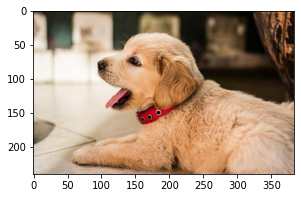

In [10]:
lr_image = img.imread(lr_image_dir)

lr_shape = lr_image.shape[:2]

print(lr_image.shape) # 이미지의 크기를 출력합니다.

plt.figure(figsize=(6,3))
plt.imshow(lr_image)

#### SRGAN 적용

In [11]:
srgan_img = apply_srgan(lr_image)

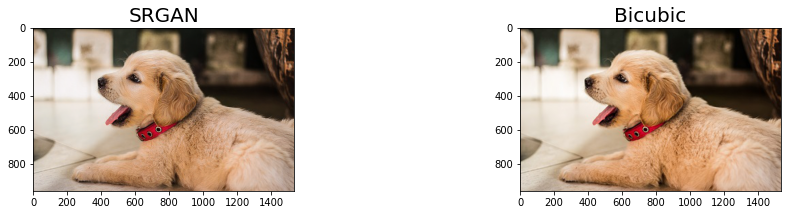

In [12]:
bicubic_image = cv2.resize(
    lr_image, 
    dsize=(lr_shape[1]*4, lr_shape[0]*4), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

images = [srgan_img, bicubic_image]
titles = ["SRGAN", "Bicubic"]

plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

#### DIV2K로 학습한 SRGAN이기 때문에 학습 데이터와 유사한 강아지(동물) 이미지를 입력으로 사용했다.
- SRGAN이 학습한 DIV2K 이미지들의 픽셀 확률 분포와 유사한 '강아지' 이미지를 입력으로 사용해서 만족스러운 SRGAN 이미지를 얻었다.

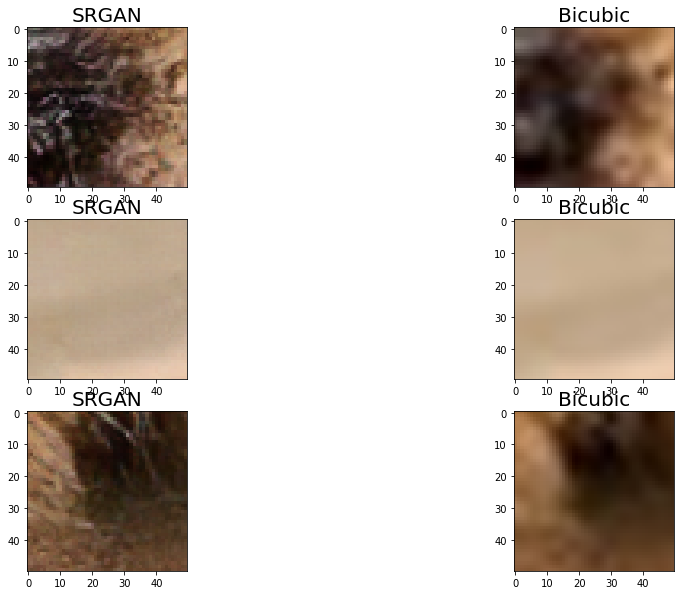

In [13]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=50):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(300,400)] *2 + [(700,500)] *2 + [(900,800)] *2

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,2,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

___

## 2. SRGAN으로 고해상도 gif 만들기

#### gif 불러오기

In [14]:
gif_dir = os.getenv('HOME') + "/aiffel/super_resolution/metro_lr.gif"
gif = cv2.VideoCapture(gif_dir)

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 35
frame 크기 : (252, 282, 3)


#### 프레임별 SR 적용하기

In [15]:
bicubic_frames = []

for f in frames :
    
    bicubic_image = cv2.resize(
    f, 
    dsize=(f.shape[1]*4, f.shape[0]*4), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
    )
    bicubic_frames.append(bicubic_image)

In [16]:
frames_sr = []

for f in frames :
    srgan_image = apply_srgan(f)
    frames_sr.append(srgan_image)

In [17]:
import imageio

imageio.mimsave("srgan.gif", frames_sr)
imageio.mimsave("bicubic.gif", bicubic_frames)

#### SRGAN

<img src="./srgan.gif" >

#### bicubic

<img src="./bicubic.gif">

#### origin

<img src="./metro_lr.gif" width="1008" height="1128"/>

___

# 정리

Super Resolution을 bicubic 기법과 **SRCNN, SRGAN**을 통해서 진행해보았다. Super Resolution의 경우 딥러닝 적용 전에도 꾸준히 연구됐던 분야지만 딥러닝 도입 이후 엄청난 성능 개선을 얻을 수 있었다. 실제로 프로젝트를 통해 **SRGAN**을 여러 영상에 적용한 결과 한눈에 봐도 엄청난 영상 화질 개선을 확인할 수 있었다. 